In [1]:
# Library of my own functions
import sys
sys.path.append("../src/")
import my_functions

# Libraries to deal with dataframes and formats
import pandas as pd 
import pickle as pkl

# Libraries to plot
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Avoids no critical warnings
plt.rcParams['figure.figsize'] = [20, 4] # Change figure size of the cell of the notebook

##  1.Compare All Models

How do we compare multiple models? 

#### Metrics
At the beginning of the project, we have to establish and optimizing metric and some satisfying metrics.

- Optimizing metric

During development, we need to try a lot of ideas about algorithm architecture, model parameters, choice of features, etc. Having a single-number evaluation metric allows us to sort all models according to this metric, and quickly decide what is the best.

For this specific problem, my optimizing metric is F1-score weighted, because it helps with the problem of the data-imbalance assigning equals weights to each class. In simple words, F1-score is the harmonic mean of precision and recall (The closer to 1 the better)

- Satisfying Metric

Define what is acceptable for the model and what is not. For example, Maximum running time of the model, false positive rate, false negative, etc. You only need to meet a certain value.

#### Complexity of the model
In general is better to have a less complex model that is explainable and that someone can understand, than having a complex model that is not explainable like a Neural Network.

##### Note:
-This part is highly inspired by Andrew Ng Coursera specialization in Deep Learning

### 1.1 Optimizing Metric

In [2]:
# Calculate optimizing metric for all models

folder_path = "../data/predictions/"
models = ["ada_boosting", "gradient_boosting", "logreg_rfecv", "random_forest", "svc", "rf_raul_featuresoriginal", "rf_original_featuresoriginal"]
dic_f1score = {}

for i in models:
    path_predictions = folder_path + i + ".csv"   

    # Calculate F1 Weighted Scores
    f1_train, f1_val = my_functions.calculate_f1score( path_predictions )

    # Save values in dictionary
    dic_f1score[i] = [f1_train, f1_val]
    dic_f1score["split"] = ["training", "validation"]

# Convert the f1 scores to a dataframe
df = pd.DataFrame(dic_f1score)
df = pd.melt(df, id_vars = ["split"]).rename(columns = {"value":"f1_weighted", "variable":"model"})  # Tidy the df
df.sort_values(["f1_weighted","split"], ascending=False, inplace=True)  

Text(0.5, 1.0, 'Optimizing Metric')

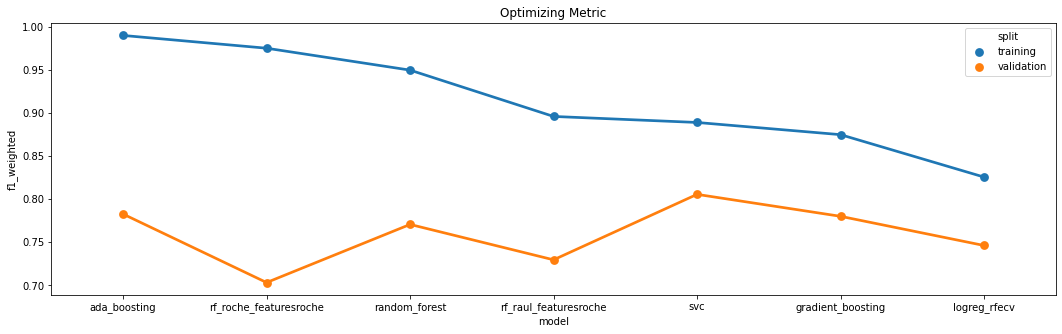

In [3]:
plt.rcParams['figure.figsize'] = [18, 5]
sns.pointplot(x="model", y="f1_weighted", data=df, hue = "split")
plt.title("Optimizing Metric") 

#### Findings Optimizing Metric

- Because there is a huge distance between the models f1-score in training and f1-score in validation, the models are overfitting the data. For the next iterations, I would focus on doing Regularization techniques (Better Hyperparameter choosing) to see if the f1-score improves.

- The best model is the SVC. However the distance between this and other models are not so great, so maybe I would choose a more understandable model like logistic regression with rfecv

### 1.2 Satisfying Metric

In [4]:
# Calculate Satisfying Metrics for All Models

folder_path = "../data/predictions/"
models = ["ada_boosting", "gradient_boosting", "logreg_rfecv", "random_forest", "svc", "rf_raul_featuresoriginal", "rf_original_featuresoriginal"]
dic_satisfyingmetric = {}

for i in models:
    path_predictions = folder_path + i + ".csv"  

    # Calculate metrics
    baccuracy_train, cohen_train, baccuracy_val, cohen_val = my_functions.calculate_satisfying_metric(path_predictions)
    
    # Put metrics in a dictionary
    dic_satisfyingmetric[i] = [baccuracy_train, cohen_train, baccuracy_val, cohen_val]
    dic_satisfyingmetric["metric"] = ["balanceacc_training", "cohen_training", "balanceacc_validation", "cohen_validation"]

df = pd.DataFrame(dic_satisfyingmetric)

# Obtain split and metric information
df["split"] = df['metric'].str.split('_').str[1]
df["metric"] = df['metric'].str.split('_').str[0]

# Tidy the data
df = pd.melt(df, id_vars = ["split", "metric"]).rename(columns = {"variable":"model"})  

Text(0.5, 1.0, 'Satisfying Metrics SVC')

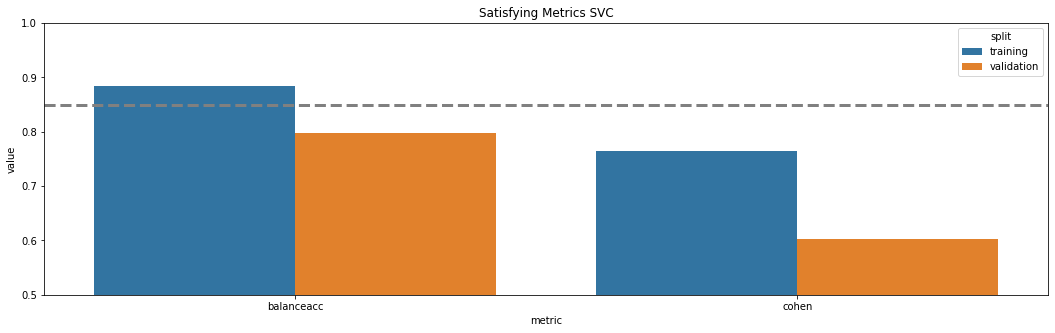

In [5]:
df = df[ df["model"] =="svc"] # Filter the model to graph

plt.rcParams['figure.figsize'] = [18, 5]
sns.barplot(x="metric", y="value", data=df, hue = "split")
plt.ylim(0.5, 1)
plt.axhline(y=0.85, linewidth=3, color='gray', linestyle='--')
plt.title("Satisfying Metrics SVC") 

#### Findings Satisfying Metrics

Both do not satisfy the conditions previously established

- Balance Accuracy: It is defined as the average of recall obtained in each class (Worst is 0 and Best is 1). It gives a better option than simple accuracy in imbalanced datasets. This metric is not so bad, but it differs a lot from the training, so the model is overfitting.

- Cohen Kappa Score (Linear Weighting): Expresses the level of agreement between two annotators on a classification problem. We can say that there is not a very good agreement between the predictions and the true label.

##  2.Evaluate SVC Model

I do these plots to understand better the model. I take the time to write those functions so it is easier to evaluate each model and with this iterate faster. Of course, I could use the sklearn built-in function, but my functions are easier and I like to customize the plots too =). I use the optimizing metrics and satisfying to take the direction of the model, but I like to plot this so nothing escapes.

Also, I plot this for every model, but I only explain SVC so my notebook is more concise.

In [6]:
input_file = "../data/predictions/svc.csv"

#### 2.1 Confusion Matrix

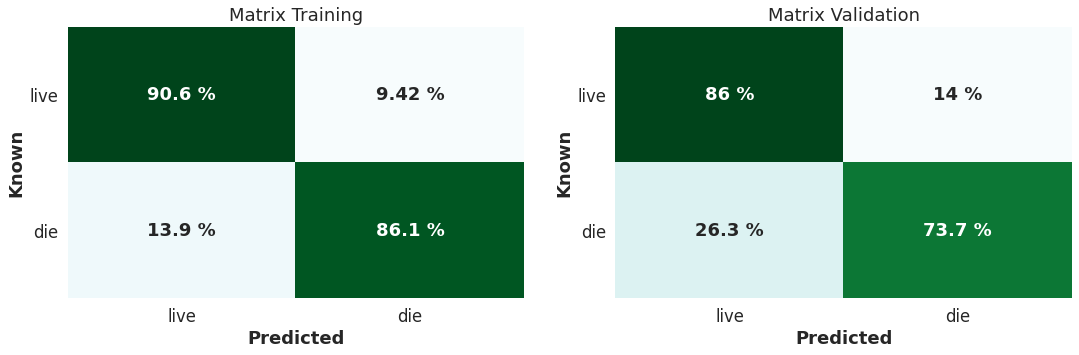

In [8]:
my_functions.plot_confusion_matrices(input_file)

#### Findings Confusion Matrix

This matrix serves to identify where the errors of the classifier are been made (Type 1 and 2 error). If for example, we were going to tell someone to travel in the Titanic base on the classifier, the worst error that we could commit is to say that he is going to live when he is going to die. 

Here we see a huge difference between the training matrix and the validation matrix (Overfitting).

#### 2.2 Classification Report

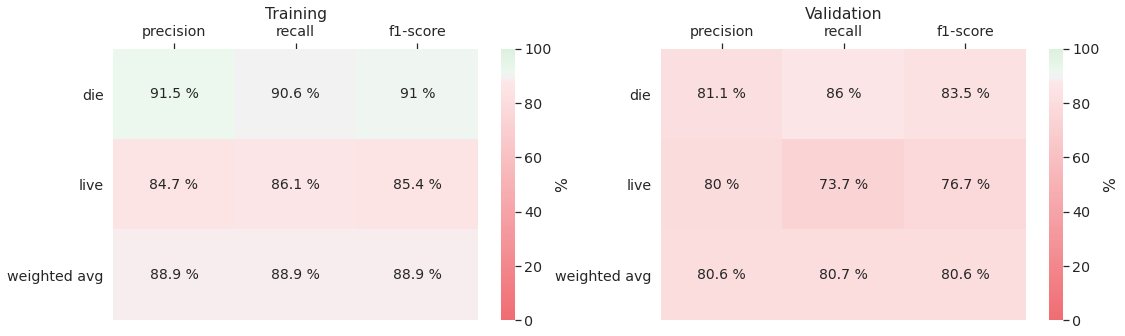

In [10]:
my_functions.plot_classification_reports(input_file)

#### Findings Classification Report

- Precision is intuitively the ability of the classifier not to label as positive a sample that is negative. 
- Recall is intuitively the ability of the classifier to find all the positive samples

I decided to use f1-score because it combines these two types of metrics. The heatmap is changed to identify where the classifier made mistakes (When it is below 90%)

#### 2.3 ROC Curves

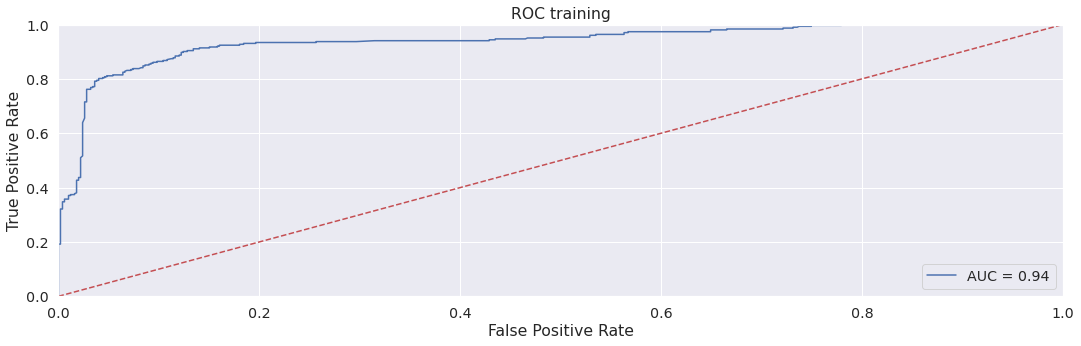

In [11]:
# Establishing parameters for ROC Curve
model = pkl.load(open("../models/features_raul/svc.pkl", 'rb'))
X, y = my_functions.create_features_target(input_file="../data/features/train_raul.pkl" , target_column="Survived", index_column="PassengerId", format_type="pickle")

# Plot ROC Curve
my_functions.plot_roc_curve(model, X, y, title = "ROC training")

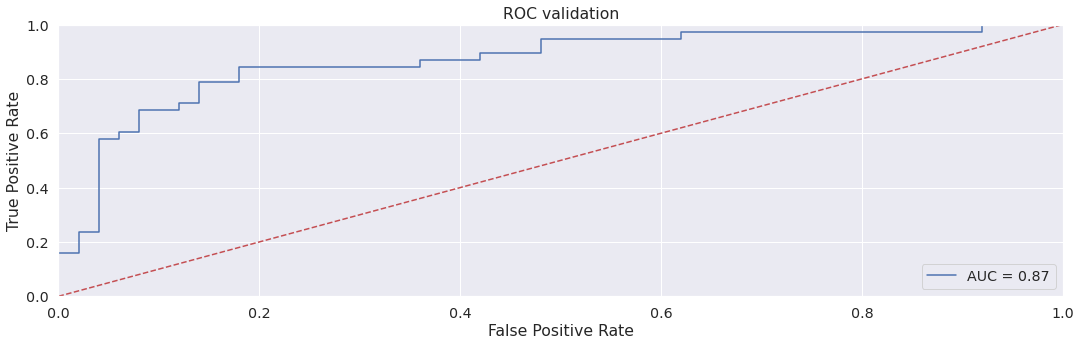

In [12]:
# Establishing parameters for ROC Curve
model = pkl.load(open("../models/features_raul/svc.pkl", 'rb'))
X, y = my_functions.create_features_target(input_file="../data/features/val_raul.pkl" , target_column="Survived", index_column="PassengerId", format_type="pickle")

# Plot ROC Curve
my_functions.plot_roc_curve(model, X, y, title = "ROC validation")

#### Findings ROC Curve

The AUC tells how much model is capable of distinguishing between classes is the metric of the area under the curve (Worst is 0 and Best is 1)

Here the model is not very good in AUC of the validation set, because it differs a lot from the training set.